uncomment if executing in google colab

In [1]:
# ! pip uninstall pyro-ppl
# ! pip install pyro-ppl==1.5.1
# ! unzip fonts.zip 
# ! unzip claptchagen.zip
# ! unzip csis
# ! cp csis.py /usr/local/lib/python3.7/dist-packages/pyro/infer

In [2]:
import random
import string
import os
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time

from torch.autograd import Variable
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from claptchagen.claptcha import Claptcha
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from gmade import GMADE
import matplotlib.pyplot as plt
print(pyro.__version__)

captcha_folder = 'generated_captchas'
captchaHeight = 32
captchaWidth = 100
captchaMarginX = 4
captchaMarginY = 4
batch_size = 10

char_dict = string.digits
#char_dict = "abc"
USE_CUDA = True
MAX_N = 4 # maximum number of letters in a captcha 
MIN_N = 2 # minimum number of letters in a captcha
MIN_NOISE = 0.01 # minimum noise
MAX_NOISE = 0.99 # maximum noise
smoke_test = False
num_steps = 400 if not smoke_test else 10
TrainingSample = 2000 if not smoke_test else 100 # number of captchas generated for training 
hidden_state_dim = 32

def randomString():
    """
    return a string with <num_char> random letters
    """
    k = random.randint(MIN_N, MAX_N) # sample number of characters
    
    rndLetters = (random.choice(char_dict) for _ in range(k))
    
    pad_spaces = MAX_N - k # pad the string so the captcha is close to center
    space = " " * (pad_spaces // 2)
    
    return space + "".join(rndLetters) + space

def ramdomNoise():
    """
    return a float between MIN_NOISE, MAX_NOISE
    """
    return random.uniform(MIN_NOISE, MAX_NOISE)

def generate_random_captcha(n, save=False):
    """
    generate n random captchas,
    return a list of texts on the captchas
    """
    # Initialize Claptcha object with random text, FreeMono as font, of size
    # 100x30px, using bicubic resampling filter and adding a bit of white noise
    c = Claptcha(randomString, "fonts/FreeSans.ttf", (captchaWidth, captchaHeight), (captchaMarginX, captchaMarginY),
             resample=Image.BILINEAR, noise=0)
    captcha_generated = [ [] for i in range(MAX_N)]
    for i in range(n):
        c.noise = ramdomNoise()
        if save:
            text, _ = c.write(os.path.join(captcha_folder, 'captcha{}.png'.format(i)))
            os.rename(os.path.join(captcha_folder, 'captcha{}.png'.format(i)),os.path.join(captcha_folder, '{}.png'.format(text + "_" + str(i))))
        text, image = c.image
        text = text.strip()
        image = np.array(image)[:, :, 0] # the generator is gray scale, only keep one channel is enough
        captcha_generated[len(text) - 1].append((text, image, c.noise))
    return captcha_generated
    
captcha_generated = generate_random_captcha(TrainingSample, save=False)
for lst in captcha_generated:
    print("number of samples in group", len(lst))
    # print some sample captcha information generated
    for i, t in enumerate(lst):
        print("text", t[0], "captcha shape", t[1].shape, "noise", t[2])
        if i >= 10:
            break

1.7.0
number of samples in group 0
number of samples in group 706
text 65 captcha shape (32, 100) noise 0.3638508752252425
text 70 captcha shape (32, 100) noise 0.771595891769132
text 60 captcha shape (32, 100) noise 0.5892370633482786
text 34 captcha shape (32, 100) noise 0.8696821508311234
text 17 captcha shape (32, 100) noise 0.3272283769864158
text 61 captcha shape (32, 100) noise 0.14081404941687237
text 93 captcha shape (32, 100) noise 0.19881421845787214
text 36 captcha shape (32, 100) noise 0.26146754025140695
text 70 captcha shape (32, 100) noise 0.4538270162785919
text 99 captcha shape (32, 100) noise 0.2021532477702203
text 42 captcha shape (32, 100) noise 0.6711037900974994
number of samples in group 654
text 676 captcha shape (32, 100) noise 0.6966769092893221
text 832 captcha shape (32, 100) noise 0.48893516217139776
text 393 captcha shape (32, 100) noise 0.23549312998552815
text 776 captcha shape (32, 100) noise 0.09789889559949842
text 658 captcha shape (32, 100) noise 

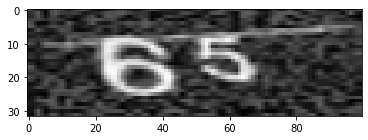

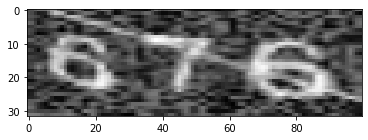

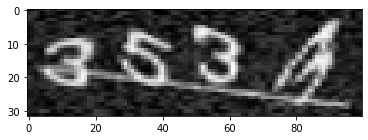

In [3]:
for lst in captcha_generated:
    if len(lst) > 0:
        plt.imshow(lst[0][1], cmap="Greys")
        plt.show()

In [4]:
def render_image(chars, fonts="fonts/FreeSans.ttf", size=(captchaWidth, captchaHeight), 
                 margin=(captchaMarginX, captchaMarginY), resample=Image.BILINEAR, noise=0.3, use_cuda=False):
    #noise = noise.data.item()
    #print(chars, noise)
    pad_spaces = MAX_N - len(chars)
    space = " " * (pad_spaces // 2)
    chars = space + chars + space
    render = Claptcha(chars, fonts, size, margin, resample=resample, noise=noise)

    
    _ , rendered_image = render.image
    rendered_image = np.array(rendered_image)[:,:,0] # the generator is gray scale, only keep one channel is enough
    rendered_image = np.subtract(np.divide(rendered_image, 255), 0.5)
    rendered_image = torch.from_numpy(rendered_image)
    if use_cuda:
        rendered_image = rendered_image.cuda()
    return rendered_image

In [5]:
class CaptchaDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, raw_captchas, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.raw_captchas = raw_captchas
        self.transform = transform

    def __len__(self):
        return len(self.raw_captchas)

    def __getitem__(self, idx):
        label = self.raw_captchas[idx][0]
        image = self.raw_captchas[idx][1]
        noise = self.raw_captchas[idx][2]
        
        image = np.subtract(np.divide(image, 255), 0.5)
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        return label, image, noise

In [6]:
def make_loarders(BATCH_SIZE, raw_samples):
    dataloaders = [] # dataloaders for different num of char
    for lst in raw_samples:
        if lst:
            ds = CaptchaDataset(lst)
            dataloader = DataLoader(ds, batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=0, drop_last=True)
            dataloaders.append(dataloader)
    return dataloaders

def make_batches(dataloaders):
    all_batches = []
    for dl in dataloaders:
        for i_batch, sample in enumerate(dl):
            all_batches.append(sample)
    random.shuffle(all_batches)
    random.shuffle(all_batches)
    return all_batches

TrainLoaders = make_loarders(BATCH_SIZE=batch_size, raw_samples=captcha_generated)

In [7]:
class NoiseNet(nn.Module):

    def __init__(self, img_size, out_size = 1):
        """
        Network for learning noise in a captcha
        """
        super(NoiseNet, self).__init__()
        
        self.img_size = img_size
        self.fc0 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.fc1 = nn.Linear(img_size[0] * img_size[1], 1024)
        
        self.fc2 = nn.Linear(1024, 1024)
        self.fc20 = nn.Linear(1024, img_size[0] * img_size[1])
        self.fc21 = nn.Linear(img_size[0] * img_size[1], out_size)
        self.softplus = nn.Softplus()
    
    def forward(self, img):
        BS = img.shape[0]
        img = img.reshape(-1, self.img_size[0] * self.img_size[1])
        hidden = F.relu(self.fc0(img))
        hidden = self.fc1(hidden)
        # mean of noise, used in normal distribution
        noise_map = self.fc20(F.relu(self.fc2(F.relu(hidden))))
        mean =  self.fc21(F.relu(noise_map))
        # std used in normal distribution
        sigma = torch.tensor([[1e-8] for _ in range(BS)]).float()
        if USE_CUDA:
            sigma = sigma.cuda()
        return mean, sigma, noise_map

In [8]:
class NumNet(nn.Module):
    def __init__(self, img_size, out_size = 3):
        """
        Network for learning N, number of letters in a captcha
        """
        super(NumNet, self).__init__()
        self.neural_net = nn.Sequential(
            nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1] * 2),
            nn.ReLU(),
            nn.Linear(img_size[0] * img_size[1] * 2, 256),
            nn.ReLU(),
            nn.Linear(256, out_size),
            nn.LogSoftmax(dim=1))
  
    def forward(self, img):
        img = torch.reshape(img, (img.shape[0], img.shape[1] * img.shape[2]))
        prob = self.neural_net(img)
        return prob

In [9]:
class InputEmbedding(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(InputEmbedding, self).__init__()
        self.img_size = img_size
        
        # observe layers
        self.nnfc = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.convBN1 = nn.BatchNorm2d(64)
        self.convBN2 = nn.BatchNorm2d(64)
        self.convBN3 = nn.BatchNorm2d(64)

    def forward(self, img, noise_map):
        
        BATCH_SIZE = img.shape[0]
        img = torch.reshape(img, (BATCH_SIZE, 1, self.img_size[0], self.img_size[1]))

        img = self.pool(F.relu(self.convBN1(self.conv1(img))))
        img = self.pool(F.relu(self.convBN2(self.conv2(img))))
        img = self.pool(F.relu(self.convBN3(self.conv3(img))))
        
        img = torch.reshape(img, (BATCH_SIZE, 1280))
        return img

In [10]:
class CharNetSingle(nn.Module):
    def __init__(self, img_size, output_size, MAX_N):
        """
        Network for letters in a captcha, given the noise and number of letters
        """
        super(CharNetSingle, self).__init__()
        self.img_size = img_size
        
        # branches
        self.pfc1 = nn.Linear(1280 + hidden_state_dim + 1, 2048)
        self.pfc2 = nn.Linear(2048, 1024)
        self.pfc3 = nn.Linear(1024, 1024)
        self.pfc4 = nn.Linear(1024, output_size)

    def forward(self, img_embedded, hid, noise_batch):
        
        BATCH_SIZE = img_embedded.shape[0]

        img = torch.cat((img_embedded, hid, noise_batch), 1)
        
        out = F.relu(self.pfc1(img))
        out = F.relu(self.pfc2(out))
        out = F.relu(self.pfc3(out))
        out = self.pfc4(out)
        out = F.log_softmax(out, dim=1)
        
        return out

In [11]:
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 1)
        #print(input_x, input_x.shape)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)

In [12]:
def inference(t, use_cuda=False):
    """
    one epoch of inference (iterate the training set once)
    """
    start = time.time()
    loss = 0
    length = TrainingSample
    loss_group = []
    all_batches = make_batches(TrainLoaders)
    for i_batch, sample_batched in enumerate(all_batches):
        
        img = sample_batched[1]
        if use_cuda:
            img = img.cuda()
        IMG = {"captcha" : img}
        imme_loss = csis.step(observations=IMG)
        loss += imme_loss / length
        del IMG, img

    print("loss at epoch {} is {}".format(t, loss), end="; ")
    print("Epoch takes", round(time.time()- start), "seconds")
    return loss

In [13]:
test_accuracies = []
test_char_accuracies = []
test_noise_differences = []
train_accuracies = []
train_char_accuracies = []
train_noise_differences = []

def test(n = 0, use_train=False, verbose=False, use_cuda=False):
    """
    benchmarking performance on customized or training set
    """
    global test_accuracies, test_char_accuracies, train_accuracies, train_char_accuracies, train_noise_differences, test_noise_differences
    if use_train:
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=captcha_generated)
    else:
        test_captcha_generated = generate_random_captcha(n, save=False)
        TestLoaders = make_loarders(BATCH_SIZE=1, raw_samples=test_captcha_generated)
    
    total_correct = 0
    char_correct = 0
    total_char = 0
    all_batches = make_batches(TestLoaders)
    noise_difference = 0
    for i_batch, t in enumerate(all_batches):

        label = t[0][0]
        gt_noise = t[2][0]
        img = t[1]

        if use_cuda:
            img = img.cuda()
        
        IMG = {"captcha" : img}
        
        posterior = csis.run(observations=IMG)
        marginal_num = pyro.infer.EmpiricalMarginal(posterior, "num_char")
        marginal_noise = pyro.infer.EmpiricalMarginal(posterior, "noise")
        with torch.no_grad():

            N_index = marginal_num()
            N = N_index + captchaModel.num_char_domain[0]
            noise = captchaModel._map_to_noise_range(marginal_noise()[0])
            sampled_chars = []
            
            # sample characters one by one
            for i in range(N):
                marginal_char = pyro.infer.EmpiricalMarginal(posterior, "char_{}".format(i))()[0]
                if use_cuda:
                    marginal_char.cpu()
                sampled_chars.append(marginal_char)
        
        chars = ""
        for i in range(len(sampled_chars)):
            c = sampled_chars[i]
            chars +=  captchaModel.char_dict[c]
        correct = 0
        
        for p_char, t_char in zip(chars, label):
            if p_char == t_char:
                correct += 1
        noise_difference += abs(float(noise) - float(gt_noise))
        if not verbose:
            print("N_predicted:", int(N), "| Actual N:", len(label), "| Predicted Noise:", round(float(noise), 3), "| Actual Noise:", round(float(gt_noise), 3), "| Predicted Text:", chars, "| Actual Text:", label, "| Correct:", correct)
        if correct == len(label) and int(N) == len(label):
            total_correct += 1
        char_correct += correct
        total_char += len(label)
    num_test_samples = i_batch + 1
    accuracy = total_correct / num_test_samples
    char_accuracy = char_correct / total_char
 
    
    noise_difference = noise_difference / num_test_samples
    if use_train:
        train_accuracies.append(accuracy)
        train_char_accuracies.append(char_accuracy)
        train_noise_differences.append(noise_difference)
    elif n > 10:
        test_accuracies.append(accuracy)
        test_char_accuracies.append(char_accuracy)
        test_noise_differences.append(noise_difference)
    print("use_train =", use_train, "AVG Noise Difference:", noise_difference, "Total correct:", total_correct, "accuracy:{}/{}=".format(total_correct, num_test_samples), accuracy, "char_accuracy:{}/{}=".format(char_correct, total_char), char_accuracy)


In [14]:

losses  = []
def test_cycle(use_cuda):
    
    # disable dropout
#     captchaModel.numNet.eval()
#     captchaModel.charNetSingle.eval()
    test(use_train=True, verbose=True, use_cuda=use_cuda)
    test(1000, use_train=False, verbose=True, use_cuda=use_cuda)
    #test(10, use_train=True, verbose=False, use_cuda=use_cuda)
    test(10, use_train=False, verbose=False, use_cuda=use_cuda)
    # enable dropout
#     captchaModel.numNet.train()
#     captchaModel.charNetSingle.train()

def optimize(start_epoch=1, use_cuda=False):
    """
    Training/Inferencing Stage
    """
    loss_sequence = []
    pause = 5
    save_pause = 10
    print("Optimizing...")
    for t in range(start_epoch, num_steps + 1):
        L = inference(t, use_cuda)
        loss_sequence.append(L)
        losses.append(L)
        if (t % pause == 0) and (t > 0):
            test_cycle(use_cuda=use_cuda)
        #if (t % save_pause == 0) and (t > 0):
        #    save_and_download_checkpoints("branches-1-no-var-no-tanh_model.pt", "branches-1-no-var-no-tanh_optim.pt", "branches-1-no-var-no-tanh_param_store.pt")
    plt.plot(loss_sequence)
    plt.title("loss")
    plt.show()

In [15]:
# saves the model and optimizer states to disk
def save_checkpoint(currentModel, currentOptimzier, save_model, save_opt, save_param_store):
    print("saving model to %s..." % save_model)
    torch.save(currentModel.state_dict(), save_model)
    print("saving optimizer states to %s..." % save_opt)
    currentOptimzier.save(save_opt)
    print("saving pyro pram store states to %s..." % save_param_store)
    pyro.get_param_store().save(save_param_store)
    print("done saving checkpoints to disk.")

# loads the model and optimizer states from disk
def load_checkpoint(myModel, myOptimzer, load_model, load_opt, load_param_store):
    pyro.clear_param_store()
    print("loading model from %s..." % load_model)
    myModel.load_state_dict(torch.load(load_model))
    print("loading optimizer states from %s..." % load_opt)
    myOptimzer.load(load_opt)
    print("loading pyro pram store states from %s..." % load_param_store)
    pyro.get_param_store().load(load_param_store)
    print("done loading states.")
    pyro.module("guide", myModel, update_module_params=True)

def save_and_download_checkpoints(save_model, save_opt, save_param_store):
    save_checkpoint(captchaModel, optimiser, save_model, save_opt, save_param_store)
def save_metric_to_disk(file_path):
    import json
    save_dict = {
        "test_accuracies" : test_accuracies,
        "test_char_accuracies" : test_char_accuracies,
        "test_noise_differences" : test_noise_differences,
        "train_accuracies"  : train_accuracies,
        "train_char_accuracies"  : train_char_accuracies,
        "train_noise_differences" : train_char_accuracies
    }
    with open(file_path, 'w') as fout:
        json.dump(save_dict, fout)

Optimizing...


C:\Users\frank\anaconda3\envs\pyro-env\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss at epoch 1 is 7.564507908582683; Epoch takes 121 seconds
loss at epoch 2 is 7.0178830549716995; Epoch takes 120 seconds
loss at epoch 3 is 6.870405701875685; Epoch takes 120 seconds
loss at epoch 4 is 6.688413067102433; Epoch takes 122 seconds
loss at epoch 5 is 6.579338250637056; Epoch takes 120 seconds
use_train = True AVG Noise Difference: 0.23630858903450275 Total correct: 9 accuracy:9/2000= 0.0045 char_accuracy:605/5934= 0.10195483653522076
use_train = False AVG Noise Difference: 0.23440356079607788 Total correct: 6 accuracy:6/1000= 0.006 char_accuracy:304/2964= 0.10256410256410256
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.612 | Actual Noise: 0.563 | Predicted Text: 6149 | Actual Text: 8906 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.664 | Actual Noise: 0.609 | Predicted Text: 844 | Actual Text: 715 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.639 | Actual Noise: 0.197 | Predicted Text: 8805 | Actual Text: 7562 | Correct: 0
N_predi

loss at epoch 23 is 4.640833320140839; Epoch takes 131 seconds
loss at epoch 24 is 4.636789535760879; Epoch takes 132 seconds
loss at epoch 25 is 4.529492522358896; Epoch takes 138 seconds
use_train = True AVG Noise Difference: 0.1391847819731895 Total correct: 23 accuracy:23/2000= 0.0115 char_accuracy:1031/5934= 0.17374452308729357
use_train = False AVG Noise Difference: 0.14085473638638327 Total correct: 9 accuracy:9/1000= 0.009 char_accuracy:518/2998= 0.17278185456971315
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.545 | Actual Noise: 0.481 | Predicted Text: 58 | Actual Text: 39 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.728 | Actual Noise: 0.812 | Predicted Text: 318 | Actual Text: 779 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.669 | Actual Noise: 0.652 | Predicted Text: 911 | Actual Text: 041 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.431 | Actual Noise: 0.291 | Predicted Text: 13 | Actual Text: 44 | Correct: 0
N_pre

loss at epoch 44 is 3.845894881725311; Epoch takes 130 seconds
loss at epoch 45 is 3.7375390974283214; Epoch takes 135 seconds
use_train = True AVG Noise Difference: 0.1315405723788992 Total correct: 34 accuracy:34/2000= 0.017 char_accuracy:1202/5934= 0.20256150994270306
use_train = False AVG Noise Difference: 0.1325268635751907 Total correct: 19 accuracy:19/1000= 0.019 char_accuracy:646/3057= 0.21131828590121032
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.765 | Actual Noise: 0.946 | Predicted Text: 9765 | Actual Text: 6938 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.551 | Actual Noise: 0.653 | Predicted Text: 3118 | Actual Text: 2738 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.486 | Actual Noise: 0.216 | Predicted Text: 173 | Actual Text: 278 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.488 | Actual Noise: 0.421 | Predicted Text: 80 | Actual Text: 70 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.756 | Actua

loss at epoch 65 is 3.1288455599546423; Epoch takes 133 seconds
use_train = True AVG Noise Difference: 0.13411299350206557 Total correct: 49 accuracy:49/2000= 0.0245 char_accuracy:1473/5934= 0.24823053589484328
use_train = False AVG Noise Difference: 0.12750250061998683 Total correct: 31 accuracy:31/1000= 0.031 char_accuracy:720/2988= 0.24096385542168675
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.454 | Actual Noise: 0.347 | Predicted Text: 393 | Actual Text: 454 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.744 | Actual Noise: 0.803 | Predicted Text: 3386 | Actual Text: 9859 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.755 | Actual Noise: 0.774 | Predicted Text: 477 | Actual Text: 777 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.375 | Actual Noise: 0.046 | Predicted Text: 6570 | Actual Text: 5607 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.789 | Actual Noise: 0.926 | Predicted Text: 42 | Actual Text: 52 | Co

use_train = False AVG Noise Difference: 0.11851225434766602 Total correct: 39 accuracy:39/1000= 0.039 char_accuracy:869/2979= 0.2917086270560591
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.411 | Actual Noise: 0.332 | Predicted Text: 18 | Actual Text: 48 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.669 | Actual Noise: 0.678 | Predicted Text: 438 | Actual Text: 409 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.433 | Actual Noise: 0.34 | Predicted Text: 80 | Actual Text: 60 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.821 | Actual Noise: 0.894 | Predicted Text: 49 | Actual Text: 32 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.712 | Actual Noise: 0.872 | Predicted Text: 772 | Actual Text: 242 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.797 | Actual Noise: 0.876 | Predicted Text: 85 | Actual Text: 68 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.639 | Actual Noise: 0.646 | Predic

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.846 | Actual Noise: 0.972 | Predicted Text: 20 | Actual Text: 15 | Correct: 0
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.768 | Actual Noise: 0.977 | Predicted Text: 010 | Actual Text: 240 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.71 | Actual Noise: 0.753 | Predicted Text: 3891 | Actual Text: 3691 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.429 | Actual Noise: 0.323 | Predicted Text: 60 | Actual Text: 90 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.461 | Actual Noise: 0.368 | Predicted Text: 509 | Actual Text: 514 | Correct: 1
use_train = False AVG Noise Difference: 0.13668157365225472 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:10/29= 0.3448275862068966
loss at epoch 106 is 2.0304695679545395; Epoch takes 133 seconds
loss at epoch 107 is 2.0049351486861706; Epoch takes 123 seconds
loss at epoch 108 is 2.0092559484541423; Epoch takes 116 seconds
loss at epoch 109 is 1

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.748 | Actual Noise: 0.653 | Predicted Text: 05 | Actual Text: 08 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.44 | Actual Noise: 0.075 | Predicted Text: 782 | Actual Text: 682 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.408 | Actual Noise: 0.15 | Predicted Text: 01 | Actual Text: 06 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.79 | Actual Noise: 0.972 | Predicted Text: 6790 | Actual Text: 6440 | Correct: 2
use_train = False AVG Noise Difference: 0.13322109151681677 Total correct: 0 accuracy:0/10= 0.0 char_accuracy:11/28= 0.39285714285714285
loss at epoch 126 is 1.5118839316517108; Epoch takes 117 seconds
loss at epoch 127 is 1.4860581523105514; Epoch takes 116 seconds
loss at epoch 128 is 1.496500042557715; Epoch takes 114 seconds
loss at epoch 129 is 1.4577527820169938; Epoch takes 114 seconds
loss at epoch 130 is 1.442875099137427; Epoch takes 116 seconds
use_train = True AVG Nois

N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.432 | Actual Noise: 0.13 | Predicted Text: 62 | Actual Text: 80 | Correct: 0
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.415 | Actual Noise: 0.026 | Predicted Text: 90 | Actual Text: 00 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.435 | Actual Noise: 0.088 | Predicted Text: 80 | Actual Text: 27 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.682 | Actual Noise: 0.667 | Predicted Text: 8917 | Actual Text: 8911 | Correct: 3
use_train = False AVG Noise Difference: 0.17711597477245003 Total correct: 1 accuracy:1/10= 0.1 char_accuracy:13/29= 0.4482758620689655
loss at epoch 146 is 1.0662762867659328; Epoch takes 115 seconds
loss at epoch 147 is 1.0741706305714325; Epoch takes 114 seconds
loss at epoch 148 is 1.0775863989098002; Epoch takes 114 seconds
loss at epoch 149 is 1.0398100289879366; Epoch takes 114 seconds
loss at epoch 150 is 1.0152426794481002; Epoch takes 115 seconds
use_train = True AVG Noi

N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.567 | Actual Noise: 0.526 | Predicted Text: 029 | Actual Text: 028 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.689 | Actual Noise: 0.624 | Predicted Text: 61 | Actual Text: 61 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.718 | Actual Noise: 0.673 | Predicted Text: 33 | Actual Text: 30 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.461 | Actual Noise: 0.243 | Predicted Text: 91 | Actual Text: 21 | Correct: 1
use_train = False AVG Noise Difference: 0.10171766224734533 Total correct: 1 accuracy:1/10= 0.1 char_accuracy:15/28= 0.5357142857142857
loss at epoch 166 is 0.8442973264111203; Epoch takes 114 seconds
loss at epoch 167 is 0.8432633162530835; Epoch takes 116 seconds
loss at epoch 168 is 0.8070734121724968; Epoch takes 115 seconds
loss at epoch 169 is 0.7939673623527929; Epoch takes 115 seconds
loss at epoch 170 is 0.7573705324260513; Epoch takes 117 seconds
use_train = True AVG Nois

loss at epoch 186 is 0.6266963726730317; Epoch takes 123 seconds
loss at epoch 187 is 0.610859660730881; Epoch takes 121 seconds
loss at epoch 188 is 0.5952089350877032; Epoch takes 119 seconds
loss at epoch 189 is 0.5723734972834355; Epoch takes 120 seconds
loss at epoch 190 is 0.5656032106420028; Epoch takes 119 seconds
use_train = True AVG Noise Difference: 0.1233938140676848 Total correct: 377 accuracy:377/2000= 0.1885 char_accuracy:3296/5934= 0.555443208628244
use_train = False AVG Noise Difference: 0.12490705315835382 Total correct: 194 accuracy:194/1000= 0.194 char_accuracy:1679/2989= 0.5617263298762127
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.392 | Actual Noise: 0.031 | Predicted Text: 2302 | Actual Text: 2309 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.602 | Actual Noise: 0.692 | Predicted Text: 9076 | Actual Text: 9076 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.369 | Actual Noise: 0.047 | Predicted Text: 8669 | Actual Text: 5859

loss at epoch 206 is 0.463013639859739; Epoch takes 180 seconds
loss at epoch 207 is 0.4256064711516265; Epoch takes 178 seconds
loss at epoch 208 is 0.45399255843683184; Epoch takes 177 seconds
loss at epoch 209 is 0.4268005046828657; Epoch takes 177 seconds
loss at epoch 210 is 0.41175665677138007; Epoch takes 175 seconds
use_train = True AVG Noise Difference: 0.12338075721265424 Total correct: 419 accuracy:419/2000= 0.2095 char_accuracy:3451/5934= 0.5815638692281766
use_train = False AVG Noise Difference: 0.11814629598191678 Total correct: 225 accuracy:225/1000= 0.225 char_accuracy:1769/2956= 0.5984438430311232
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.764 | Actual Noise: 0.942 | Predicted Text: 3992 | Actual Text: 5952 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.694 | Actual Noise: 0.771 | Predicted Text: 684 | Actual Text: 864 | Correct: 1
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.778 | Actual Noise: 0.861 | Predicted Text: 588 | Actual Text: 555

loss at epoch 227 is 0.3252831341922282; Epoch takes 171 seconds
loss at epoch 228 is 0.340364157906326; Epoch takes 180 seconds
loss at epoch 229 is 0.314214028251812; Epoch takes 171 seconds
loss at epoch 230 is 0.3346724714748742; Epoch takes 174 seconds
use_train = True AVG Noise Difference: 0.12157410413696522 Total correct: 497 accuracy:497/2000= 0.2485 char_accuracy:3666/5934= 0.6177957532861477
use_train = False AVG Noise Difference: 0.12541367309690102 Total correct: 254 accuracy:254/1000= 0.254 char_accuracy:1783/2933= 0.607909989771565
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.707 | Actual Noise: 0.849 | Predicted Text: 3421 | Actual Text: 9828 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.757 | Actual Noise: 0.746 | Predicted Text: 7340 | Actual Text: 7780 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.545 | Actual Noise: 0.536 | Predicted Text: 740 | Actual Text: 740 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.727

loss at epoch 248 is 0.2558137239135867; Epoch takes 113 seconds
loss at epoch 249 is 0.268796452084789; Epoch takes 115 seconds
loss at epoch 250 is 0.22585173747770015; Epoch takes 115 seconds
use_train = True AVG Noise Difference: 0.12530453852728068 Total correct: 534 accuracy:534/2000= 0.267 char_accuracy:3752/5934= 0.632288506909336
use_train = False AVG Noise Difference: 0.12297207749230157 Total correct: 256 accuracy:256/1000= 0.256 char_accuracy:1877/2993= 0.6271299699298363
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.684 | Actual Noise: 0.658 | Predicted Text: 714 | Actual Text: 714 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.423 | Actual Noise: 0.367 | Predicted Text: 8636 | Actual Text: 5838 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.607 | Actual Noise: 0.552 | Predicted Text: 9995 | Actual Text: 9995 | Correct: 4
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.398 | Actual Noise: 0.124 | Predicted Text: 2844 | Actual Text: 454

loss at epoch 268 is 0.1999036462229433; Epoch takes 115 seconds
loss at epoch 269 is 0.16360212786656472; Epoch takes 115 seconds
loss at epoch 270 is 0.13887313928659561; Epoch takes 114 seconds
use_train = True AVG Noise Difference: 0.12212925663859035 Total correct: 553 accuracy:553/2000= 0.2765 char_accuracy:3799/5934= 0.6402089652847994
use_train = False AVG Noise Difference: 0.12161416073311278 Total correct: 269 accuracy:269/1000= 0.269 char_accuracy:1943/2998= 0.6480987324883255
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.426 | Actual Noise: 0.25 | Predicted Text: 58 | Actual Text: 67 | Correct: 0
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.414 | Actual Noise: 0.295 | Predicted Text: 5019 | Actual Text: 5013 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.403 | Actual Noise: 0.232 | Predicted Text: 40 | Actual Text: 49 | Correct: 1
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.759 | Actual Noise: 0.983 | Predicted Text: 8285 | Actual Text: 9208 |

loss at epoch 288 is 0.12523116416897392; Epoch takes 113 seconds
loss at epoch 289 is 0.10633425063954934; Epoch takes 114 seconds
loss at epoch 290 is 0.11155310038560858; Epoch takes 114 seconds
use_train = True AVG Noise Difference: 0.12566667735494272 Total correct: 569 accuracy:569/2000= 0.2845 char_accuracy:3856/5934= 0.6498146275699359
use_train = False AVG Noise Difference: 0.12196128544841725 Total correct: 298 accuracy:298/1000= 0.298 char_accuracy:1991/3014= 0.6605839416058394
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.686 | Actual Noise: 0.748 | Predicted Text: 6391 | Actual Text: 9393 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.803 | Actual Noise: 0.958 | Predicted Text: 957 | Actual Text: 967 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.444 | Actual Noise: 0.451 | Predicted Text: 204 | Actual Text: 204 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.392 | Actual Noise: 0.05 | Predicted Text: 54 | Actual Text: 54 

loss at epoch 308 is -0.02248768300130906; Epoch takes 114 seconds
loss at epoch 309 is -0.03664812569956121; Epoch takes 113 seconds
loss at epoch 310 is -0.0025689144990210513; Epoch takes 112 seconds
use_train = True AVG Noise Difference: 0.12150421588096777 Total correct: 646 accuracy:646/2000= 0.323 char_accuracy:3990/5934= 0.6723963599595552
use_train = False AVG Noise Difference: 0.11740653678337187 Total correct: 302 accuracy:302/1000= 0.302 char_accuracy:2016/3001= 0.6717760746417861
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.71 | Actual Noise: 0.739 | Predicted Text: 822 | Actual Text: 892 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.445 | Actual Noise: 0.366 | Predicted Text: 29 | Actual Text: 29 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.641 | Actual Noise: 0.637 | Predicted Text: 9584 | Actual Text: 9684 | Correct: 3
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.816 | Actual Noise: 0.973 | Predicted Text: 37 | Actual Text: 3

loss at epoch 328 is -0.2232424624452323; Epoch takes 114 seconds
loss at epoch 329 is -0.22084682178886214; Epoch takes 113 seconds
loss at epoch 330 is -0.23303666797345063; Epoch takes 113 seconds
use_train = True AVG Noise Difference: 0.12154018747311601 Total correct: 695 accuracy:695/2000= 0.3475 char_accuracy:4127/5934= 0.6954836535220762
use_train = False AVG Noise Difference: 0.12208483981252546 Total correct: 321 accuracy:321/1000= 0.321 char_accuracy:2094/3043= 0.6881367071968452
N_predicted: 4 | Actual N: 3 | Predicted Noise: 0.468 | Actual Noise: 0.424 | Predicted Text: 8072 | Actual Text: 807 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.347 | Actual Noise: 0.154 | Predicted Text: 3893 | Actual Text: 3893 | Correct: 4
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.514 | Actual Noise: 0.542 | Predicted Text: 152 | Actual Text: 160 | Correct: 1
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.432 | Actual Noise: 0.316 | Predicted Text: 65 | Actual Text:

loss at epoch 349 is -0.3722115592048575; Epoch takes 113 seconds
loss at epoch 350 is -0.3490589427994273; Epoch takes 113 seconds
use_train = True AVG Noise Difference: 0.12455156557885969 Total correct: 769 accuracy:769/2000= 0.3845 char_accuracy:4254/5934= 0.7168857431749242
use_train = False AVG Noise Difference: 0.1268215031610088 Total correct: 384 accuracy:384/1000= 0.384 char_accuracy:2183/3031= 0.720224348399868
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.399 | Actual Noise: 0.14 | Predicted Text: 9624 | Actual Text: 8629 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.779 | Actual Noise: 0.901 | Predicted Text: 529 | Actual Text: 829 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.372 | Actual Noise: 0.356 | Predicted Text: 666 | Actual Text: 666 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.38 | Actual Noise: 0.014 | Predicted Text: 8842 | Actual Text: 9802 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.43

loss at epoch 369 is -0.41492130252605414; Epoch takes 115 seconds
loss at epoch 370 is -0.43384731479961924; Epoch takes 114 seconds
use_train = True AVG Noise Difference: 0.12126124015555738 Total correct: 776 accuracy:776/2000= 0.388 char_accuracy:4297/5934= 0.7241321199865184
use_train = False AVG Noise Difference: 0.12349188832500162 Total correct: 382 accuracy:382/1000= 0.382 char_accuracy:2128/2970= 0.7164983164983165
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.777 | Actual Noise: 0.971 | Predicted Text: 6132 | Actual Text: 5832 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.444 | Actual Noise: 0.235 | Predicted Text: 830 | Actual Text: 530 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.689 | Actual Noise: 0.723 | Predicted Text: 35 | Actual Text: 35 | Correct: 2
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.416 | Actual Noise: 0.261 | Predicted Text: 081 | Actual Text: 081 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.5

loss at epoch 389 is -0.44709368261636656; Epoch takes 113 seconds
loss at epoch 390 is -0.4552543512573756; Epoch takes 114 seconds
use_train = True AVG Noise Difference: 0.12528240310881592 Total correct: 834 accuracy:834/2000= 0.417 char_accuracy:4359/5934= 0.7345803842264914
use_train = False AVG Noise Difference: 0.11897920134713828 Total correct: 400 accuracy:400/1000= 0.4 char_accuracy:2185/2988= 0.7312583668005355
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.381 | Actual Noise: 0.227 | Predicted Text: 8054 | Actual Text: 8064 | Correct: 3
N_predicted: 3 | Actual N: 3 | Predicted Noise: 0.422 | Actual Noise: 0.329 | Predicted Text: 068 | Actual Text: 058 | Correct: 2
N_predicted: 2 | Actual N: 2 | Predicted Noise: 0.801 | Actual Noise: 0.928 | Predicted Text: 00 | Actual Text: 00 | Correct: 2
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.513 | Actual Noise: 0.5 | Predicted Text: 8913 | Actual Text: 6913 | Correct: 3
N_predicted: 4 | Actual N: 4 | Predicted Noise: 0.403 

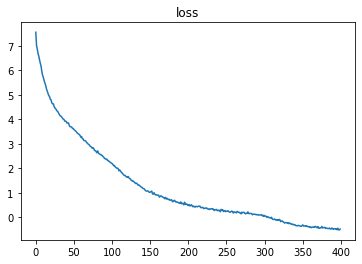

In [16]:
def mask_operation(i, n):
    return i < (n + MIN_N)
    
class CaptchaModel(nn.Module):
    """
    network, model and guide wrapper class
    """
    def __init__(self, use_cuda=False):
        super().__init__()
        self.num_char_domain = torch.arange(MIN_N, MAX_N + 1)
        if use_cuda:
            self.num_char_domain = self.num_char_domain.cuda()

        #self.numNet = NumNet((captchaHeight, captchaWidth), len(self.num_char_domain))
        #self.noiseNet = NoiseNet((captchaHeight, captchaWidth), 1)
        self.char_dict = char_dict # letter dictionary
        #self.charNet = CharNetSingle((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain)) # with noise
        self.inputEmbedding = InputEmbedding((captchaHeight, captchaWidth), len(self.char_dict), max(self.num_char_domain))
        self.noise_constraint = torch.distributions.constraints.interval(MIN_NOISE, MAX_NOISE)
        self.hid_net = simpleNN(hidden_state_dim + len(char_dict) + MAX_N + 1, hidden=128, out_size = hidden_state_dim, t = "mlp")
        #self.h0 = nn.Parameter(torch.zeros(hidden_state_dim))
        self.noise_dim = 128
        self.charRNN = nn.RNN(1280 + MAX_N + 2, 256, 2, nonlinearity='relu', dropout=0.1, batch_first=False)
        self.charLinearMap = nn.Linear(256, len(self.char_dict))
        #self.charLinearMaps = nn.ModuleList([nn.Linear(256, len(self.char_dict)) for i in range(MAX_N)])
        self.nlinearMap = nn.Linear(256, len(self.num_char_domain))
        self.noiselinearMapLoc = nn.Linear(256, 1)
        self.noiselinearMapStd = nn.Linear(256, 1)
        
        self.h_0 = nn.Parameter(torch.zeros(2, 1, 256))
        self.softplus = nn.Softplus()
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
    
    def _map_to_noise_range(self, input):
        """
        map input number to the valid noise range
        """
        input = torch.distributions.transform_to(self.noise_constraint)(input)
        return input

    # update from old captcha model/guide:
    # using mask to zero out index > num_char, this is a generalization of the previous version where we take the mean 
    # and assume num_char is the same for the entire batch

    def guide(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        img = observations["captcha"].float()
        BS = img.shape[0]
        
        # posterior to the number of letters
        
        with pyro.plate("data", img.shape[0]):
            prob = self.numNet(img)
            #prob = torch.mean(prob, dim=0)
            N_index = pyro.sample("num_char", dist.Categorical(prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            
            # posterior to the noise
            noise_mean, noise_sig, noise_map = self.noiseNet(img)
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            input_emb = self.inputEmbedding(img, noise_map)
            h = self.h0.expand(BS, -1)
            
            for i in range(MAX_N):
                # tranform index to one-hot representation
                i_input = torch.tensor(i)
                if USE_CUDA:
                    i_input = i_input.cuda()
                i_input = F.one_hot(i_input, num_classes=MAX_N).float()
                i_input = i_input.repeat(BS, 1)
                # whether the character has ends
                sample_mask = i < N_index
                charP_i = self.charNet(input_emb, h, noise_batch)
                c_i = pyro.sample("char_{}".format(i), dist.Categorical(charP_i).mask(sample_mask).to_event(0))
                c_i = F.one_hot(c_i, num_classes=len(self.char_dict)).float()
                # update the hidden state
                h = self.hid_net([h, c_i, i_input, sample_mask.float().unsqueeze(1)])
                
                
    def guide_rnn_all_1(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        pyro.module("guide", self)
        
        img = observations["captcha"].float()
        BS = img.shape[0]
        # flatten representation of img
        input_emb = self.inputEmbedding(img, None)
                
        with pyro.plate("data", img.shape[0]):
            
            N = MAX_N + 2
            i = torch.arange(0, int(N))
            if USE_CUDA:
                i = i.cuda()
            i_onehot = F.one_hot(i, num_classes=N).float() # one hot format of N and index of letter
            i_onehot = torch.reshape(i_onehot, (N, 1, N)).repeat(1, BS, 1)
            input_emb = input_emb.unsqueeze(0).repeat(N, 1, 1)
            rnn_input = torch.cat((input_emb, i_onehot), dim=2) # input to rnn
            h_0_contig = self.h_0.expand(2, BS, 256).contiguous() # init hidden state
            outputs, hn = self.charRNN(rnn_input, h_0_contig)
            # sample N
            N_prob = F.log_softmax(self.nlinearMap(outputs[1]), dim=1)
            N_index = pyro.sample("num_char", dist.Categorical(N_prob).to_event(0))
            N_index = torch.add(N_index, self.num_char_domain[0])
            # sample noise
            noise_loc = self.noiselinearMapLoc(outputs[2])
            noise_std = self.softplus(self.noiselinearMapStd(outputs[2]))
            noise_batch = pyro.sample("noise", dist.Normal(noise_loc, noise_std).to_event(1))
            # sample char
            for i in range(2, N):
                char_index = i - 2
                sample_mask = char_index < N_index
                char_i = F.log_softmax(self.charLinearMap(outputs[char_index]), dim=1)
                c_i = pyro.sample("char_{}".format(char_index), dist.Categorical(char_i).mask(sample_mask).to_event(0))      
    
    def model_rec(self, observations={"captcha": torch.rand(1, captchaHeight, captchaWidth)}):
        
        BS = observations["captcha"].shape[0]
        
        with pyro.plate("data", BS):
            
            
            num_p = torch.tensor(1 / len(self.num_char_domain)).repeat(len(self.num_char_domain)).unsqueeze(0).repeat(BS, 1)
        
            if self.use_cuda:
                num_p = num_p.cuda()

            # sample the number of characters
            N_index = pyro.sample("num_char", dist.Categorical(num_p).to_event(0))
            
            N_index = torch.add(N_index,  self.num_char_domain[0])
            
            noise_mean = torch.tensor((MAX_NOISE - MIN_NOISE) / 2).repeat((BS, 1))
            noise_sig = torch.tensor(0.5).repeat((BS, 1))

            if self.use_cuda:
                noise_mean = noise_mean.cuda()
                noise_sig = noise_sig.cuda()

            # sample the noise
            noise_batch = pyro.sample("noise", dist.Normal(noise_mean, noise_sig).to_event(1))
            noise_batch = self._map_to_noise_range(noise_batch)
            
            sampled_c = []
            
            def _rec(i):
                if i < MAX_N:
                    sample_mask = i < N_index
                    num_c_i = torch.tensor(1 / len(self.char_dict)).repeat((BS, len(self.char_dict)))
                    if self.use_cuda:
                        num_c_i = num_c_i.cuda()
                    c_i = pyro.sample("char_{}".format(i), dist.Categorical(num_c_i).mask(sample_mask).to_event(0))
                    sampled_c.append((sample_mask, c_i))
                    _rec(i + 1)
            _rec(0)
                
            # sample characters
            rendered_images = []
            
            # does not contain any sample statements
            def _render_imgs(i):
                
                def _get_chars(j, chars, i):
                    if j < MAX_N:
                        if sampled_c[j][0][i]:
                            chars += self.char_dict[sampled_c[j][1][i]]
                            return _get_chars(j + 1, chars, i)
                    return chars
                if i < BS:
                    chars = ""
                    chars = _get_chars(0, "", i)
                    #print("chars", chars)
                    rendered_image = render_image(chars, noise=float(noise_batch[i]), use_cuda=self.use_cuda)
                    rendered_images.append(rendered_image)
                    _render_imgs(i + 1)
                    
            _render_imgs(0)
     
        rendered_images = torch.stack(rendered_images)
        sigma = torch.tensor(0.000001)
        if self.use_cuda:
                sigma = sigma.cuda()

        pyro.sample("captcha", dist.Normal(rendered_images, sigma).to_event(2), obs=observations["captcha"])

captchaModel = CaptchaModel(USE_CUDA)

optimiser = pyro.optim.Adam({'lr': 5e-5})
csis = pyro.infer.CSIS(captchaModel.model_rec, captchaModel.guide_rnn_all_1, optimiser, num_inference_samples=1)

optimize(1, USE_CUDA)
# test_cycle(USE_CUDA)
save_metric_to_disk("captcha_metrics_noise_in_charnet_rnn_400_all_rv.json")


In [17]:
save_metric_to_disk("captcha_metrics_noise_in_charnet_rnn_400_all_rv.json")

Logs